In [1]:
import math 
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# Diciconarie of abailable stocks/indexes with page reference of the excel file
# This can be replaced with direct download from yfinance
dic = pd.read_excel(r'/content/Datos BBG.xlsx', sheet_name=5)
dic

,Index
0,Merval
1,MADX
2,FTSE MIB
3,DAX
4,UKX


In [7]:
#Wich index would you choose
id = 1

In [8]:
data_backup = pd.read_excel(r'/content/Datos BBG.xlsx', sheet_name=id)

In [9]:
# Import data. Generates data_backup with original data. 
# mer: includes trade volume, Interest rate and M2 money supply in case to be included
# dpx : generates a dataframe only with price and returns. Also adds a column of the 1st difference of prices.
data_backup = pd.read_excel(r'/content/Datos BBG.xlsx', sheet_name=id) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
mer = data_backup
dpx = mer[['Date','PX','PXret']]
dpx = dpx[dpx['PXret'].notnull()] #generates a new DF with Price and Returns
dpx['PXdiff'] = dpx.PX.diff() # Add a column with 1st differences
dpx['PXvol'] = dpx.PXret.abs()
date = dpx['Date']
dpxd = dpx #Equal to dpx but with date as index
dpxd = dpxd.set_index('Date')
lsty = dpx.tail(250)
#dpx = dpx.set_index('Date')
#yrl= pd.DataFrame(np.unique(dpx.Date.year))#Create a df of years for store data of each year
#yrl.rename( columns={0 :'Year'}, inplace=True )
#mer = mer.dropna() #is it ok to drop NaN values
#mer = mer.reset_index()
#mer = mer.drop('index', axis=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
mer=mer.set_index('Date')
dpx #keep index as order of observations

,Date,PX,PXret,PXdiff,PXvol
1,1993-02-19,233.200,0.005,NaN,0.005
2,1993-02-22,232.300,-0.004,-0.900,0.004
3,1993-02-23,227.800,-0.019,-4.500,0.019
4,1993-02-24,227.900,0.000,0.100,0.000
5,1993-02-25,228.000,0.000,0.100,0.000
...,...,...,...,...,...
7551,2022-12-23,823.570,-0.000,-0.220,0.000
7552,2022-12-27,823.830,0.000,0.260,0.000
7553,2022-12-28,822.810,-0.001,-1.020,0.001
7554,2022-12-29,828.870,0.007,6.060,0.007


Text(0, 0.5, 'Price')

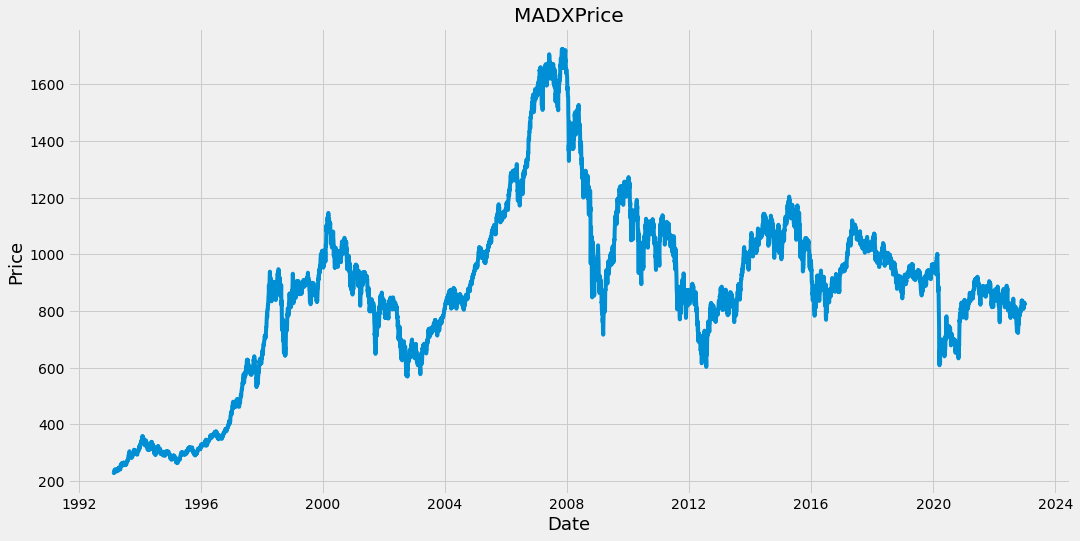

In [17]:
plt.figure(figsize=(16,8))
plt.title(dic.Index[id] + 'Price')
plt.plot(dpxd.PX)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)

In [33]:
# Create a new df with only close column
dprice = dpx['PX']

#Convert the data to a numpy array
dpr1 = dprice.values

#Set train data
train_len = len(dpr[:-20]) #train is all but last 20
train_len

7529

In [34]:
#Solve the error expecting 2d array.
dpr = dpr1[:,np.newaxis]

In [35]:
# Scale the data. All values must be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dpr = scaler.fit_transform(dpr)
scaled_dpr

array([[0.00360685],
       [0.00300571],
       [0.        ],
       ...,
       [0.39742845],
       [0.40147614],
       [0.39569181]])

In [38]:
# Create the training dataset from scaled data
train_dpr = scaled_dpr[0:train_len, :]
# Split between x_train and y_train
x_train = []
y_train = []

#Use last 60 values to predict the coming ones
for i in range (60, len(train_dpr)):
  x_train.append(train_dpr[i-60:i,  0])
  y_train.append(train_dpr[i, 0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([3.60685302e-03, 3.00571085e-03, 0.00000000e+00, 6.67935745e-05,
       1.33587149e-04, 3.33967872e-03, 5.87783455e-03, 5.20989881e-03,
       4.80913736e-03, 5.34348596e-03, 7.14691247e-03, 8.48278396e-03,
       8.88354540e-03, 8.34919681e-03, 8.41599038e-03, 6.67935745e-03,
       5.87783455e-03, 5.14310523e-03, 4.77574057e-03, 5.74424740e-03,
       3.13929800e-03, 4.34158234e-03, 4.40837591e-03, 5.20989881e-03,
       7.21370604e-03, 7.94843536e-03, 9.15071970e-03, 8.34919681e-03,
       7.88164179e-03, 6.54577030e-03, 6.27859600e-03, 5.34348596e-03,
       5.00951808e-03, 7.48088034e-03, 8.14881608e-03, 7.48088034e-03,
       8.01522893e-03, 1.08873526e-02, 1.05533848e-02, 9.75186187e-03,
       1.19560498e-02, 1.09541462e-02, 1.22833383e-02, 1.07871623e-02,
       1.12814347e-02, 1.01392646e-02, 1.10676953e-02, 1.11010921e-02,
       1.04999499e-02, 1.00858297e-02, 9.99899810e-03, 9.01045319e-03,
       8.40931102e-03, 9.62495408e-03, 9.38449721e-03, 1.60371372e-02,
     

In [39]:
# Convert x_train and y_train to numpy arrays so it can be used to LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [43]:
#Reshape the data because it expects to be 3-d and now it is 2-d
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(7469, 60, 1)

In [44]:
#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [46]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1) #epochs: number of times data goes back and forth in the NN. batch: how meany samples at time to train

7469/7469 [==============================] - 214s 28ms/step - loss: 5.9618e-04


In [48]:
# Create the testing data set
#Create a new array containing scaled values 
test_dpr = scaled_dpr[len(train_dpr):]

#Create the data sets x_test and y_test
x_test=[]
y_test=dpr[train_len:, :]
for i in range (60, len(test_dpr)):
  x_test.append(test_dpr[i-60:i, 0])

In [49]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [54]:
#Solve the error expecting 2d array.
x_test = x_test[:,np.newaxis]

In [55]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [57]:
# Get the models predicted price values
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)

ValueError: ignored